# Lab 4-6: Mixture Models+Model orden selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by November 8, 2018 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

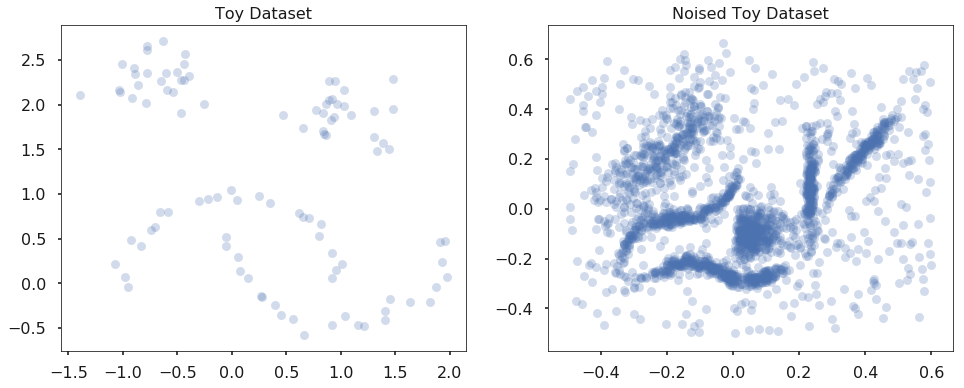

In [11]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class:

In [170]:
class my_GMM():
    
    def __init__(self, k, initialization="kmeans"):
        '''
        Attributes:
        
        k_: integer
            number of components
        initialization_: {"kmeans", "random"}
            type of initialization
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.initialization_ = initialization
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.M = None
        
    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        
        def compute_condition_prob_matrix(X, mu, Sigma, p): 
            #Compute P(Z=K | X= xi)
            num_samples = X.shape[0]
            condition_matrix = np.zeros((num_samples, self.k_))
             
            for i in range(num_samples):
                for k in range(self.k_):
                    condition_matrix[i, k] = p[k]*multivariate_normal.pdf(X[i, :], mu[k], Sigma[k], allow_singular=True)
                sum_i = np.sum(condition_matrix[i, :])
                condition_matrix[i, :] = condition_matrix[i, :] / sum_i
            
            return(condition_matrix)
        
        # Initialization
        num_samples, num_features = X.shape
        p = np.zeros(self.k_)
        self.Sigma_ = []
        
        if self.initialization_ == 'kmeans':   
            kmeans = KMeans(n_clusters= self.k_, random_state=0).fit(X)
            self.mu_ = kmeans.cluster_centers_
            self.labels_ = kmeans.labels_
            
            # Proportion of data point in each cluster
            p = np.bincount(self.labels_)/num_samples 
            
            classLabels = np.unique(self.labels_)
            
            # List of data points in each cluster
            partition = [np.where(self.labels_ == num_label)[0] for num_label in classLabels]
            
            for k in range(self.k_):
                Sigma = np.zeros((num_features, num_features))
                for idx in partition[k]:
                    Sigma = Sigma + (X[idx,:] - self.mu_[k]).T @ (X[idx,:] - self.mu_[k])
                self.Sigma_.append(Sigma / (num_samples * p[k]))
                
        # While not(convergence): 
        for nb_ in range(10):
            
            self.cond_prob_ = compute_condition_prob_matrix(X, self.mu_, self.Sigma_, p)
            
            #Update labels
            for i in range(num_samples):
                self.labels_[i] = np.argmax(self.cond_prob_[i, :]) 
            
            #Update parameters
            
            #Update pk
            for k in range(self.k_):
                p[k] = sum(self.cond_prob_[:, k])/num_samples
            
            #Update mu
            for k in range(self.k_):
                mu = np.zeros(num_features)
                for i in range(num_samples):
                    #update self.mu_
                    mu += X[i, :]*self.cond_prob_[i, k]
                self.mu_[k, :] = mu/(num_samples*p[k])
            
            #Update Sigma
            self.Sigma_ = []
            for k in range(self.k_):
                Sigma = np.zeros((num_features, num_features))
                for i in range(num_samples):
                    Sigma = Sigma + self.cond_prob_[i, k]*((X[i,:] - self.mu_[k, :]).T @ (X[i,:] - self.mu_[k, :]))
                self.Sigma_.append(Sigma / (num_samples * p[k]))
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment 
        
        """
        num_samples, num_features = X.shape
        
        self.fit(X)
        
        # Return labels
        for i in range(num_samples):
            self.labels_[i] = np.argmax(self.cond_prob_[i, :])  
        return(self.labels_)
        
    def predict_proba(self, X):
        """ Predict probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        
        num_samples, num_features = X.shape
        self.fit(X)
        return(self.cond_prob_)

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [171]:
model_0 = my_GMM(k = 5)
model_0.fit(test_data_0)

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
Implement the seen model selection methods (This part may be updated for the next lab)

## Application

You are going to work with the following data:

shape: (1797, 64)


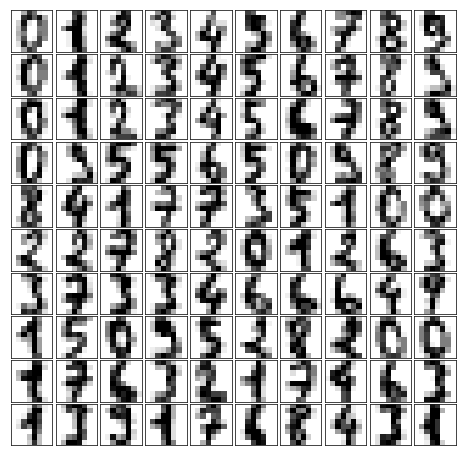

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method and produce new synthetic handwritten numbers. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [ ]:
# TODO